# Classification Project

The goal is to build a classification model to predict if median housing prices in some districts are below or above a certain level (150000).

## Python Setup

In [19]:
import pandas as pd
import numpy as np 

import seaborn as sns
sns.set_theme(style='ticks')

import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split
import sklearn.linear_model as skl_lm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Datenvorbereitung

### Daten laden

In [2]:
GIT = "https://raw.githubusercontent.com/jan-kirenz/project-annikas428/main/"
DATA = "project_data.csv"
TOKEN = "?token=GHSAT0AAAAAABPURMBOEW2WS3JEBXGI5TPAYPJRBIQ"

df_initial = pd.read_csv(GIT + DATA + TOKEN)

### Datentransformation

Die Daten werden hier analog dem Notebook Regression transformiert. Auf eine ausführliche Beschreibung wird an dieser Stelle verzichtet. Die Details wurden bereits im Notebook Regression ausgeführt.

In [3]:
# drop rows with missing values
df = df_initial.dropna()
print(df.isnull().sum())

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
price_category        0
dtype: int64


In [4]:
# Convert data types Ocean_Proximity and Price_Category to Data Type "Category" as they are categorical variables (ordinal)
df.ocean_proximity = df.ocean_proximity.astype('category')

# Housing_Median_Age and Median_House_Value are actually int64 values, but pandas did not get this because of signs like '€'
df.housing_median_age = df.housing_median_age.str.replace('years', '', regex=False)
df.median_house_value = df.median_house_value.str.replace('$', '', regex=False)
df.housing_median_age = pd.to_numeric(df.housing_median_age, errors='coerce').astype('int64')
df.median_house_value = pd.to_numeric(df.median_house_value, errors='coerce').astype('float64')
df.total_bedrooms = df.total_bedrooms.astype('int64')
df.info()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20433 non-null  float64 
 1   latitude            20433 non-null  float64 
 2   housing_median_age  20433 non-null  int64   
 3   total_rooms         20433 non-null  int64   
 4   total_bedrooms      20433 non-null  int64   
 5   population          20433 non-null  int64   
 6   households          20433 non-null  int64   
 7   median_income       20433 non-null  float64 
 8   median_house_value  20433 non-null  float64 
 9   ocean_proximity     20433 non-null  category
 10  price_category      20433 non-null  object  
dtypes: category(1), float64(4), int64(5), object(1)
memory usage: 1.7+ MB


Die Variable _price_category_ gibt an, ob der _median_house_value_ eines Distrikts über bzw. unter einem Wert von 150000$ liegt. <br>
Nachfolgend wird die Variable, welche in dieser Classification als abhängige Variable genutzt wird, initialisiert.

In [5]:
#Correct price_category
df['price_category'] = np.where(df['median_house_value'] > 150000.0, 'above', 'below')
df.price_category = df.price_category.astype('category')
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20433 non-null  float64 
 1   latitude            20433 non-null  float64 
 2   housing_median_age  20433 non-null  int64   
 3   total_rooms         20433 non-null  int64   
 4   total_bedrooms      20433 non-null  int64   
 5   population          20433 non-null  int64   
 6   households          20433 non-null  int64   
 7   median_income       20433 non-null  float64 
 8   median_house_value  20433 non-null  float64 
 9   ocean_proximity     20433 non-null  category
 10  price_category      20433 non-null  category
dtypes: category(2), float64(4), int64(5)
memory usage: 1.6 MB


C:\Users\Admin\AppData\Local\Temp/ipykernel_17404/969160978.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_category'] = np.where(df['median_house_value'] > 150000.0, 'above', 'below')


In [6]:
df = df.assign(people_per_household=lambda df: df.population / df.households)
df = df.assign(rooms_per_household=lambda df: df.total_rooms / df.households)
df = df.assign(bedrooms_per_people=lambda df: df.total_bedrooms / df.population)
df = df.assign(bedrooms_per_rooms=lambda df: df.total_bedrooms / df.total_rooms)

In [8]:
# write out a dict with the mapping of old to new
remap_cat_dict = {
    'NEAR OCEAN': 'NEAR COAST',
    'NEAR BAY': 'NEAR COAST',
    'ISLAND': 'NEAR COAST',
    'INLAND': 'INLAND',
    '<1H OCEAN': 'NEAR COAST' }

df.ocean_proximity = df.ocean_proximity.map(remap_cat_dict).astype('category')

## Datensplit

In [61]:
train_dataset = df.sample(frac=0.8, random_state=0) 
test_dataset = df.drop(train_dataset.index)

train_dataset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,price_category,people_per_household,rooms_per_household,bedrooms_per_people,bedrooms_per_rooms
14185,-117.08,32.70,37,2176,418,1301,375,2.8750,98900.0,NEAR COAST,below,3.469333,5.802667,0.321291,0.192096
6125,-117.91,34.11,20,3158,684,2396,713,3.5250,153000.0,NEAR COAST,above,3.360449,4.429173,0.285476,0.216593
14095,-117.10,32.75,11,2393,726,1905,711,1.3448,91300.0,NEAR COAST,below,2.679325,3.365682,0.381102,0.303385
14359,-117.22,32.74,52,1260,202,555,209,7.2758,345200.0,NEAR COAST,above,2.655502,6.028708,0.363964,0.160317
18004,-121.99,37.29,32,2930,481,1336,481,6.4631,344100.0,NEAR COAST,above,2.777547,6.091476,0.360030,0.164164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6168,-117.93,34.09,35,1891,353,1093,382,4.0167,165500.0,NEAR COAST,above,2.861257,4.950262,0.322964,0.186674
4174,-118.21,34.10,36,2000,533,1234,535,3.7437,241700.0,NEAR COAST,above,2.306542,3.738318,0.431929,0.266500
3593,-118.48,34.24,32,2621,412,1285,414,6.6537,267600.0,NEAR COAST,above,3.103865,6.330918,0.320623,0.157192
5366,-118.39,34.04,44,1873,286,635,283,5.5951,461300.0,NEAR COAST,above,2.243816,6.618375,0.450394,0.152696


## Entfernen der Outlier

In [10]:
#drop people per household outliers
train_dataset = train_dataset.drop([3364, 16669, 19006])
#drop bedroooms per people outliers
train_dataset = train_dataset.drop([11862])
#drop rooms per household_outliers
train_dataset = train_dataset.drop([1913, 12447])

## EDA

In [11]:
import plotly.graph_objects as go

color = {'above': 'rgb(220,20,60)',
         'below': 'rgb(147,112,219)',
         }

fig = go.Figure()

for cat in train_dataset['price_category'].unique():
    dfp = train_dataset[train_dataset['price_category']==cat]
    fig.add_traces(go.Scattergeo(lon = dfp['longitude'],
                                lat = dfp['latitude'],
                                text = 'median house value in district: ' + dfp['median_house_value'].astype(str) + '$',
                                mode = 'markers',
                                marker = dict(color=color[cat], size=4),
                                showlegend=True, name = cat
                             ))

fig.update_layout(
        title = 'Median House Value per District',
        geo_scope='usa',
        legend_title_text='house value above / below 150k$'
    )

fig.show()

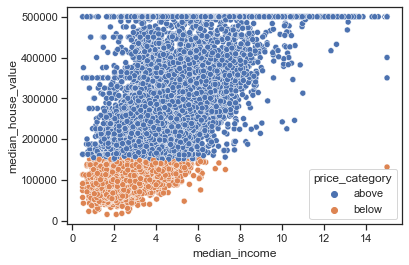

In [12]:
fig = sns.scatterplot(data= train_dataset, x='median_income', y='median_house_value', hue='price_category')

Die Variable _median_house_value_ darf in der Classification nicht verwendet werden. Da sich die abhängige Variable _price_category_ direkt aus _median_house_value_ ableitet, würde dies zu overfitting führen. <br>

Da sich _price_category_ direkt aus _median_house_value_ ableitet, können die Ergebnisse der EDA aus dem Regression Notebook auf die Classification übertragen werden.

## Modellierung

In den nachfolgenden Modellen werden die gleichen Variablen wie in der Regression verwendet. <br>
Die Variablen wurden auf Basis der Filter Methode ausgewähltn, da sie eine Korrelation zur abhängigen Variable aufweisen und somit vielversprechend sind.

### Model 1 - Statsmodels GLM

#### Model

In [13]:
model = smf.glm(formula = 'price_category ~ median_income + ocean_proximity + bedrooms_per_rooms + people_per_household' , data=train_dataset, family=sm.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Generalized Linear Model Regression Results                                  
==============================================================================================================
Dep. Variable:     ['price_category[above]', 'price_category[below]']   No. Observations:                16340
Model:                                                            GLM   Df Residuals:                    16335
Model Family:                                                Binomial   Df Model:                            4
Link Function:                                                  logit   Scale:                          1.0000
Method:                                                          IRLS   Log-Likelihood:                -5594.5
Date:                                                Tue, 18 Jan 2022   Deviance:                       11189.
Time:                                                        10:19:57   Pearson chi2:                 2.34e+09
No. Iterations:                                                     8                                         
Covariance Type:                                            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -8.0564      0.219    -36.721      0.000      -8.486      -7.626
ocean_proximity[T.NEAR COAST]     2.6241      0.057     46.102      0.000       2.513       2.736
median_income                     1.5974      0.032     49.441      0.000       1.534       1.661
bedrooms_per_rooms               10.1778      0.577     17.643      0.000       9.047      11.308
people_per_household             -0.2578      0.024    -10.609      0.000      -0.305      -0.210
=================================================================================================
"""

Die p-values der Features betragen alle 0,00. Somit ist anzunehmen, dass alle Features einen Einfluss auf die abhängige Variable haben und das Modell verbessern.

In [15]:
# Predict and join probabilty to original dataframe
train_dataset['Probability'] = model.predict()
train_dataset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,price_category,people_per_household,rooms_per_household,bedrooms_per_people,bedrooms_per_rooms,Probability
14185,-117.08,32.70,37,2176,418,1301,375,2.8750,98900.0,NEAR COAST,below,3.469333,5.802667,0.321291,0.192096,0.555058
6125,-117.91,34.11,20,3158,684,2396,713,3.5250,153000.0,NEAR COAST,above,3.360449,4.429173,0.285476,0.216593,0.823004
14095,-117.10,32.75,11,2393,726,1905,711,1.3448,91300.0,NEAR COAST,below,2.679325,3.365682,0.381102,0.303385,0.291748
14359,-117.22,32.74,52,1260,202,555,209,7.2758,345200.0,NEAR COAST,above,2.655502,6.028708,0.363964,0.160317,0.999206
18004,-121.99,37.29,32,2930,481,1336,481,6.4631,344100.0,NEAR COAST,above,2.777547,6.091476,0.360030,0.164164,0.997119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6168,-117.93,34.09,35,1891,353,1093,382,4.0167,165500.0,NEAR COAST,above,2.861257,4.950262,0.322964,0.186674,0.895335
4174,-118.21,34.10,36,2000,533,1234,535,3.7437,241700.0,NEAR COAST,above,2.306542,3.738318,0.431929,0.266500,0.934977
3593,-118.48,34.24,32,2621,412,1285,414,6.6537,267600.0,NEAR COAST,above,3.103865,6.330918,0.320623,0.157192,0.997518
5366,-118.39,34.04,44,1873,286,635,283,5.5951,461300.0,NEAR COAST,above,2.243816,6.618375,0.450394,0.152696,0.988806


Model 1 berechnet die Wahrscheinlichkeit 'Probability', dass der _median_house_value_ über 150000$ liegt (_price_category_ = 'above'). Diese Wahrscheinlichkeit wurde mit ins Trainingsset aufgenommen.

Nun werden verschiedene Classification Thresholds festgelegt. <br>
Ein Threshold definiert, aber welcher Wahrscheinlichkeit die abhängige Variable _price_category_ der Ausprägung _above_ zugeordnet wird. 

In [16]:
# Use thresholds to discretize Probability
train_dataset['Threshold 0.4'] = np.where(train_dataset['Probability'] > 0.4, 'above', 'below')
train_dataset['Threshold 0.5'] = np.where(train_dataset['Probability'] > 0.5, 'above', 'below')
train_dataset['Threshold 0.6'] = np.where(train_dataset['Probability'] > 0.6, 'above', 'below')
train_dataset['Threshold 0.7'] = np.where(train_dataset['Probability'] > 0.7, 'above', 'below')

### Confusion Matrix

In [17]:
def print_metrics(train_dataset, predicted):
    # Header
    print('-'*50)
    print(f'Metrics for: {predicted}\n')
    
    # Confusion Matrix
    y_actu = pd.Series(train_dataset['price_category'], name='Actual')
    y_pred = pd.Series(train_dataset[predicted], name='Predicted')
    df_conf = pd.crosstab(y_actu, y_pred)
    display(df_conf)
    
    # Confusion Matrix to variables:
    pop = df_conf.values.sum()
    tp = df_conf['above']['above']
    tn = df_conf['below']['below']
    fp = df_conf['above']['below']
    fn = df_conf['below']['above']
    
    # Metrics
    accuracy = (tp + tn) / pop
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    print(f'Accuracy:  {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall:    {recall:.4f}')
    print(f'F1 Score:  {f1_score:.4f} \n')

Zur Evaluation der Modellperformance wurde eine Confusion Matrix definiert. <br>
Die _price_category_ 'above' ist die positive Klasse, 'below' die negative Klasse. <br>


In [18]:
print_metrics(train_dataset, 'Threshold 0.4')
print_metrics(train_dataset, 'Threshold 0.5')
print_metrics(train_dataset, 'Threshold 0.6')
print_metrics(train_dataset, 'Threshold 0.7')

--------------------------------------------------
Metrics for: Threshold 0.4



Predicted,above,below
Actual,,
above,9603,672
below,1846,4219


Accuracy:  0.8459
Precision: 0.8388
Recall:    0.9346
F1 Score:  0.8841 

--------------------------------------------------
Metrics for: Threshold 0.5



Predicted,above,below
Actual,,
above,9312,963
below,1420,4645


Accuracy:  0.8542
Precision: 0.8677
Recall:    0.9063
F1 Score:  0.8866 

--------------------------------------------------
Metrics for: Threshold 0.6



Predicted,above,below
Actual,,
above,8899,1376
below,996,5069


Accuracy:  0.8548
Precision: 0.8993
Recall:    0.8661
F1 Score:  0.8824 

--------------------------------------------------
Metrics for: Threshold 0.7



Predicted,above,below
Actual,,
above,8260,2015
below,689,5376


Accuracy:  0.8345
Precision: 0.9230
Recall:    0.8039
F1 Score:  0.8593 



Mithilfe der Confusion Matrix werden die Classifcation Metriken 'Accuarcy', 'Prescicion', 'Recall' und 'F1 Score' für die zuvor definierten Thresholds berechnet. <br>
Die Accuray ist der Anteil aller korrekter Vorhersagen des Modells in Relation zu der Gesamtmenge an Vorhersagen. <br>
Precision gibt an, wieviel Prozent aller positiver Vorhersagen tatsächlich positiv waren. <br>
Recall berechnet sich aus der Anzahl der korrekt positiven Vorhersagen, geteilt durch die Gesamtheit aller tatsächlich positiven Datensätze. Somit gibt der Wert an, welcher Anteil der tatsächlich positivten Datensätze auch durch das Modell als solche erkannt wurden. <br>
Der F1 Score ist der harmonische Mittelwert aus Precicion und Recall. <br>

Entscheidend für die Werte von Precision und Recall ist die Wahl des Classification Threshold. Durch Erhöhung des Thresholds werden weniger Datensätze der positivten Klasse zugeordnet. Daraus resultieren weniger falsch positive Vorhersagen, jedoch verringert sich möglicherweise auch der Anteil der korrekt positiven Vorhersagen. <br>
Dadurch verbessert sich in der Regel der Precision Wert, während sich Recall verschlechtert. <br>
Die Optimierung von Precision und Recall verläuft somit gegensätzlich. Je nach Zielsetzung muss für jedes Modell individuell entschieden werden, welche der beiden Metriken optimiert werden sollte. <br>
Gilt es, falsch negative Vorhersagen (bspw. bei der Erkennung von Krankheiten) unbedingt zu vermeiden, so sollte Recall optimiert werden. <br>
<br>
Da wir in dieser Projektarbeit keine konkrete Zielstellung verfolgen, bietet sich die Optimierung des harmonischen Mittelwerts der beiden Metriken, des F1 Scores, an. <br>
Der F1 Score erreicht bei einem Threshold von 0,5 den besten Wert in Höhe von 88,66%. <br>
Die Accuracy beträgt bei diesem Threshold 85,42%, das heißt, dass 85,42% aller Vorhersagen des Modells korrekt sind. <br>
Die Precision in Höhe von 86,77% sagt aus, dass 86,77% aller positiven Vorhersagen (_price_category_ = 'above') auch tatsächlich positiv waren.
Der Recall Wert in Höhe von 90.63% bedeutet, dass 90,63% aller tatsächlich positiven Werte durch das Modell korrekt identifiziert wurden.

### Model 2 - Scikit Learn Logit


#### Data Preprocessing Pipeline

In [20]:
# for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()) #Normalisierung (X=(X-Mittelwert) / Standardabweichung)
    ])

In [21]:
# for categorical features  
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), #Konstante bei fehlenden Werten reinschreiben
    ('onehot', OneHotEncoder(dtype='float64', handle_unknown='ignore')) #pro Featureausprägung eine Spalte, zutreffendes Feature hat dann Wert 1 und die anderen Wert 0
    ])

In [22]:
# Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="category")),
    ('cat', categorical_transformer, selector(dtype_include="category"))
        ])

#### Feature Auswahl

In [23]:
# create label y
y_train = train_dataset['price_category']

In [24]:
# Select features
X_train = train_dataset[['median_income', 'ocean_proximity', 'bedrooms_per_rooms', 'people_per_household', 'housing_median_age']]

In [25]:
X_train

,median_income,ocean_proximity,bedrooms_per_rooms,people_per_household,housing_median_age
14185,2.8750,NEAR COAST,0.192096,3.469333,37
6125,3.5250,NEAR COAST,0.216593,3.360449,20
14095,1.3448,NEAR COAST,0.303385,2.679325,11
14359,7.2758,NEAR COAST,0.160317,2.655502,52
18004,6.4631,NEAR COAST,0.164164,2.777547,32
...,...,...,...,...,...
6168,4.0167,NEAR COAST,0.186674,2.861257,35
4174,3.7437,NEAR COAST,0.266500,2.306542,36
3593,6.6537,NEAR COAST,0.157192,3.103865,32
5366,5.5951,NEAR COAST,0.152696,2.243816,44


#### Model

In [27]:
# Train logistic regression model with training set in pipeline
# Create pipeline with model
logit_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logit', skl_lm.LogisticRegression(max_iter=1000))
                        ])

#Fit Model
logit_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000152D4C831C0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
      

In [28]:
# Return the mean accuracy on the given test data and labels:
print('Mean accuracy training set: ', logit_pipe.score(X_train, y_train))

Mean accuracy training set:  0.8547735618115055


In [29]:
y_pred = logit_pipe.fit(X_train, y_train).predict(X_train)

#### Confusion Matrix

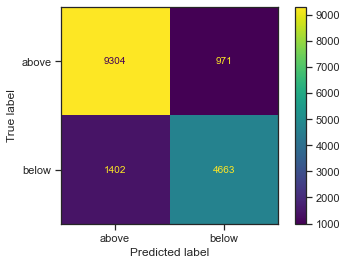

In [30]:
cm = confusion_matrix(y_train, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logit_pipe.classes_)
disp.plot()
plt.show()

Scikit Learn bietet eine gute Visualisierung der Confusion Matrix an. <br>

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_pred, target_names=['above', 'below']))

              precision    recall  f1-score   support

       above       0.87      0.91      0.89     10275
       below       0.83      0.77      0.80      6065

    accuracy                           0.85     16340
   macro avg       0.85      0.84      0.84     16340
weighted avg       0.85      0.85      0.85     16340



Scikit Learns Classification Report ermöglicht eine detaillierte Darstellung der einzelnen Metriken. <br>
Die Metriken Precision, Recall und F1 Score werden zunächst differenziert ausgegeben, je nachdem ob 'above' oder 'below' die positive Klasse darstellt. <br>
In Zeile ist wird 'above' als positive Klasse gesetzt. <br>
Marco Avg ist der ungewichtete Durchschnitt der beiden Werte pro Kennzahl. <br>
Weighted Avg gewichtet den Durchschnitt noch durch die Anzahl der tatsächlich positiven Datensätze je Label.

#### Auswahl des Thresholds

##### Threshold 0,4

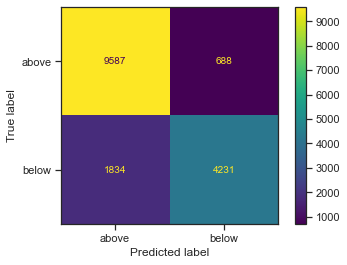

In [39]:
pred_proba = logit_pipe.predict_proba(X_train)

y_pred_threshold = np.where(pred_proba[:,0] >= .4, 'above', 'below')
cm = confusion_matrix(y_train, y_pred_threshold)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logit_pipe.classes_)
disp.plot()
plt.show()

In [40]:
print(classification_report(y_train, y_pred_threshold, target_names=['above', 'below']))

              precision    recall  f1-score   support

       above       0.84      0.93      0.88     10275
       below       0.86      0.70      0.77      6065

    accuracy                           0.85     16340
   macro avg       0.85      0.82      0.83     16340
weighted avg       0.85      0.85      0.84     16340



##### Threshold 0,5

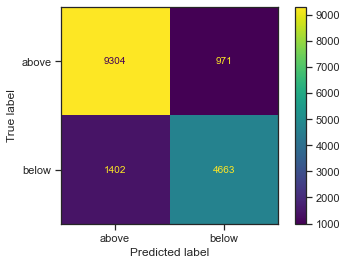

In [47]:
pred_proba = logit_pipe.predict_proba(X_train)

y_pred_threshold = np.where(pred_proba[:,0] >= .5, 'above', 'below')
cm = confusion_matrix(y_train, y_pred_threshold)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logit_pipe.classes_)
disp.plot()
plt.show()

In [48]:
print(classification_report(y_train, y_pred_threshold, target_names=['above', 'below']))

              precision    recall  f1-score   support

       above       0.87      0.91      0.89     10275
       below       0.83      0.77      0.80      6065

    accuracy                           0.85     16340
   macro avg       0.85      0.84      0.84     16340
weighted avg       0.85      0.85      0.85     16340



##### Threshold 0,6

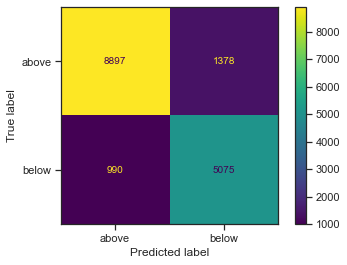

In [49]:
pred_proba = logit_pipe.predict_proba(X_train)

y_pred_threshold = np.where(pred_proba[:,0] >= .6, 'above', 'below')
cm = confusion_matrix(y_train, y_pred_threshold)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logit_pipe.classes_)
disp.plot()
plt.show()

In [50]:
print(classification_report(y_train, y_pred_threshold, target_names=['above', 'below']))

              precision    recall  f1-score   support

       above       0.90      0.87      0.88     10275
       below       0.79      0.84      0.81      6065

    accuracy                           0.86     16340
   macro avg       0.84      0.85      0.85     16340
weighted avg       0.86      0.86      0.86     16340



##### Threshold 0,7

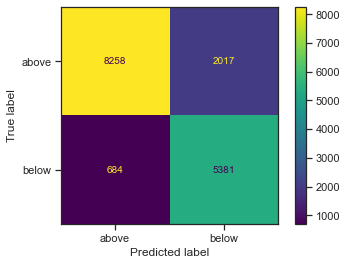

In [45]:
pred_proba = logit_pipe.predict_proba(X_train)

y_pred_threshold = np.where(pred_proba[:,0] >= .7, 'above', 'below')
cm = confusion_matrix(y_train, y_pred_threshold)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logit_pipe.classes_)
disp.plot()
plt.show()

In [46]:
print(classification_report(y_train, y_pred_threshold, target_names=['above', 'below']))

              precision    recall  f1-score   support

       above       0.92      0.80      0.86     10275
       below       0.73      0.89      0.80      6065

    accuracy                           0.83     16340
   macro avg       0.83      0.85      0.83     16340
weighted avg       0.85      0.83      0.84     16340



In Modell 2 wird der beste macro avg F1 Score in Höhe von 85% mit einem Threshold von 0,6 erzielt. <br>
Precision beträgt hier 84% und Recall 85%.


## Evaluierung mit Testdaten

In [68]:
y_test = test_dataset['price_category']

X_test = test_dataset[['median_income', 'ocean_proximity', 'bedrooms_per_rooms', 'people_per_household', 'housing_median_age']]

### Model 1

In [69]:
# Predict and join probabilty to original dataframe
test_dataset['Probability1'] = model.predict(test_dataset)
test_dataset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,price_category,people_per_household,rooms_per_household,bedrooms_per_people,bedrooms_per_rooms,Probability1
10,-122.26,37.85,52,2202,434,910,402,3.2031,281500.0,NEAR COAST,above,2.263682,5.477612,0.476923,0.197094,0.751544
13,-122.26,37.84,52,696,191,345,174,2.6736,191300.0,NEAR COAST,above,1.982759,4.000000,0.553623,0.274425,0.754084
19,-122.27,37.84,52,1503,298,690,275,2.6033,162900.0,NEAR COAST,above,2.509091,5.465455,0.431884,0.198270,0.524346
28,-122.28,37.84,50,2082,492,1131,473,1.6424,108900.0,NEAR COAST,below,2.391121,4.401691,0.435013,0.236311,0.265047
40,-122.26,37.83,52,1665,419,946,395,2.0978,155400.0,NEAR COAST,above,2.394937,4.215190,0.442918,0.251652,0.465730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20605,-121.58,39.12,26,2796,629,2017,632,1.8355,61200.0,INLAND,below,3.191456,4.424051,0.311849,0.224964,0.025153
20609,-121.56,39.11,18,2171,480,1527,447,2.3011,57500.0,INLAND,below,3.416107,4.856823,0.314342,0.221096,0.046939
20620,-121.48,39.05,40,198,41,151,48,4.5625,100000.0,INLAND,below,3.145833,4.125000,0.271523,0.207071,0.629120
20622,-121.44,39.00,20,755,147,457,157,2.4167,67000.0,INLAND,below,2.910828,4.808917,0.321663,0.194702,0.049052


Da im Modell der Threshold von 0,5 als bester Threshold in Bezug auf die zu optimierende Kennzahl F1 Score ausgewählt wurde, wird nachfolgend das Testdatenset mit diesem Threshold kategorisiert.

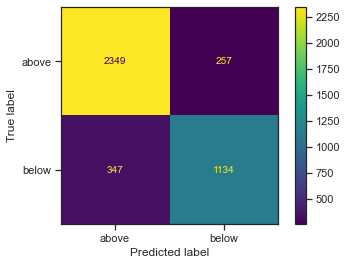

In [70]:
y_pred_threshold = np.where(test_dataset.Probability1 >= .5, 'above', 'below')
cm = confusion_matrix(y_test, y_pred_threshold)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logit_pipe.classes_)
disp.plot()
plt.show()

In [71]:
print(classification_report(y_test, y_pred_threshold, target_names=['above', 'below']))

              precision    recall  f1-score   support

       above       0.87      0.90      0.89      2606
       below       0.82      0.77      0.79      1481

    accuracy                           0.85      4087
   macro avg       0.84      0.83      0.84      4087
weighted avg       0.85      0.85      0.85      4087



### Model 2

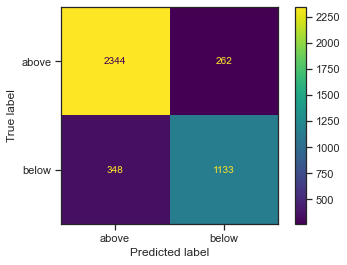

In [75]:
pred_proba = logit_pipe.predict_proba(X_test)

y_pred_threshold2 = np.where(pred_proba[:,0] >= .5, 'above', 'below')
cm = confusion_matrix(y_test, y_pred_threshold2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logit_pipe.classes_)
disp.plot()
plt.show()

In [76]:
print(classification_report(y_test, y_pred_threshold2, target_names=['above', 'below']))

              precision    recall  f1-score   support

       above       0.87      0.90      0.88      2606
       below       0.81      0.77      0.79      1481

    accuracy                           0.85      4087
   macro avg       0.84      0.83      0.84      4087
weighted avg       0.85      0.85      0.85      4087



### Ergebnis

Beide Modelle sind unter Verwendung der unbekannten Testdaten in ihrer Performance gleich geblieben. <br>
Die Modelle liefern beide mit einem F1 Score von 84% ein solides Ergebnis. Anhand der Metriken kann kein Modell bevorzugt zum Deployment ausgewählt werden. Da Scikit Learn in der Machine Learning als Bibliothek verbreiteter ist, bietet sich das Modell 2 zum Deployment an.